In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi
import skimage
from skimage import io, filters, morphology
import pandas as pd
import glob
import random
import seaborn as sns
from scipy import stats
from scipy.signal import chirp, find_peaks, peak_widths
from pathlib import Path
import scipy.stats
import os
from scipy import ndimage
import math
from operator import itemgetter
from matplotlib import pyplot
#from read_roi import read_roi_zip
from scipy.optimize import curve_fit
from scipy import signal
from scipy.interpolate import interp1d, splev, CubicSpline, PPoly
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D


In [2]:
#define functions

In [3]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [4]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [5]:
#functions to get the peak indexes for a particular channel

#get indexes of peaks for edu and hoechst channels in an array, the midpoint is the sum of the peak indexes divided by 2. Can be then converted into a distance.
def get_index(a, b):
    return (a+b)/2

#get the index of a single channel
def get_index_single_axis(a):
    return (a)

#get indexes of peaks for split smc4 or scc1 peaks for subsequent alignment the midpoint is the sum of the peak indexes divided by 2. Can be then converted into a distance.

def get_index_centre_split_axes(a,b):
    return (a+b)/2

In [6]:
#wapl depleted cells - exclude profiles where more than one peak is detected

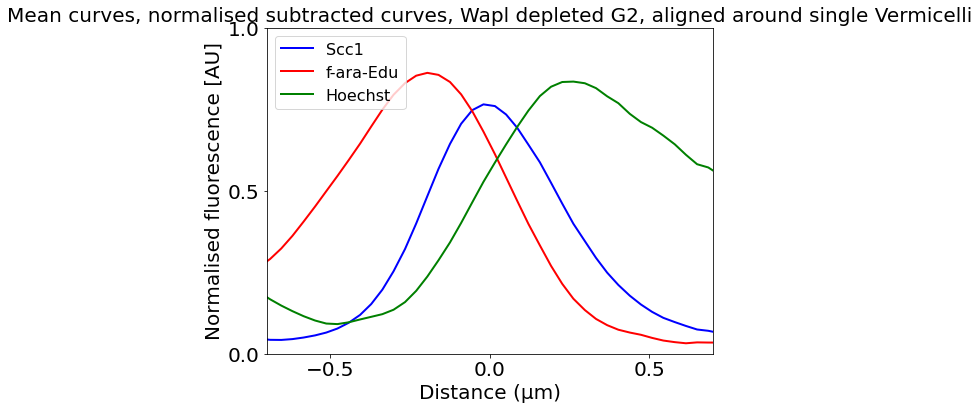

In [10]:
#plotting aligned mean curves, wapl depleted g2
#read in data
path_plot_profiles_wapl = "/groups/gerlich/experiments/Experiments_005500/005556/wapl_dep/lineprofiles3/"

csv_files = glob.glob(path_plot_profiles_wapl + "*/*.csv")

all_df = []
all_image_names = []
all_distances = []
all_scc1 = []
all_edu = []
all_hoechst = []

#set up empty lists to append
name = []
#scc1 channel
peaks1_scc1 = []
peaks2_scc1 = []
peaks1_value_scc1 = []
peaks2_value_scc1 = []

#edu channel
peaks1_edu = []
peaks1_value_edu = []

#hoechst channel
peaks1_hoechst = []
peaks1_value_hoechst = []

distance_scc1_peaks1_all = []
distance_scc1_peaks2_all = []
distance_scc1_peaks_all = []
distance_edu_peaks_all = []
distance_hoechst_peaks_all = []

for file in csv_files:
    #df = pd.read_csv(file, index_col=0, header=0)
    condition = "wapl_dep"
    split = file.split(os.sep)
    image_name = split[-2]

    #read in line profiles
    df = pd.read_csv(file, index_col = 0)
    df.columns = ['Distance', 'scc1', 'edu', 'hoechst']
    
    #set distance to variable
    distance = df.loc[:, "Distance"]
   
    #deep copy and then min/max normalisation
    df2 = df.copy()
    for column in df2.columns:
        df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())   
        
        df2["Distance"] = distance     

    #subtract edu values from hoechst values

    if np.where(df2['edu']>= df2["hoechst"]):
        df2["hoechst_minus_edu"] = (df2['hoechst'] - df2["edu"])
    
    #subtract hoechst values from edu values
    if np.where(df2['hoechst']>= df2["edu"]):
        df2["edu_minus_hoechst"] = (df2['edu'] - df2["hoechst"])

    #normalisation of subtracted data
    df3 = df2.copy()
    
    df3["hoechst_minus_edu"] = (df3["hoechst_minus_edu"] - df3["hoechst_minus_edu"].min()) / (df3["hoechst_minus_edu"].max() - df3["hoechst_minus_edu"].min())
    df3.rename(columns = {'hoechst_minus_edu':'hoechst_minus_edu_norm'}, inplace = True)

    df3["distance"] = distance
  
    #drop NaN values
    df3 = df3.dropna(axis=0)    

    #define variables
    distance = df3["distance"]
    scc1=df3["scc1"]
    edu=df3["edu"]
    hoechst = df3["hoechst_minus_edu_norm"]
    
    #for each profile
    all_image_names.append(image_name)
    all_distances.append(distance)
    all_scc1.append(scc1)
    all_edu.append(edu)
    all_hoechst.append(hoechst)   


#concat all values into dataframes, for each variable (each x position)
frame_distances = pd.concat(all_distances, axis=1, ignore_index=False)
frame_scc1 = pd.concat(all_scc1, axis=1, ignore_index=False)
frame_edu = pd.concat(all_edu, axis=1, ignore_index=False)
frame_hoechst = pd.concat(all_hoechst, axis=1, ignore_index=False)

#calculate mean for each row (each x position)  
mean_distance = (frame_distances.mean(axis=1))
mean_scc1 = (frame_scc1.mean(axis=1))
mean_edu = (frame_edu.mean(axis=1))
mean_hoechst = (frame_hoechst.mean(axis=1))

#calculate standard deviation for each row
sd_distance = (frame_distances.std(axis=1))
sd_scc1 = (frame_scc1.std(axis=1))
sd_edu = (frame_edu.std(axis=1))
sd_hoechst = (frame_hoechst.std(axis=1))

#concat dataframes back
mean_frames = [mean_distance, mean_scc1, mean_edu, mean_hoechst]
all_mean_frames = pd.concat(mean_frames, axis=1, ignore_index=False)
all_mean_frames.columns = ["distance", "scc1", "edu", "hoechst"]

sd_frames = [sd_distance, sd_scc1, sd_edu, sd_hoechst]
all_std_frames = pd.concat(sd_frames, axis=1, ignore_index=False)
all_std_frames.columns = ["distance", "scc1", "edu", "hoechst"]
all_std_frames.columns = ["distance", "std_scc1", "std_edu", "std_hoechst"]


# align individual curves - plot on the same axes

#fit the data using polynomial fit
#scc1 channel
p = np.poly1d(np.polyfit(all_mean_frames["distance"],all_mean_frames["scc1"], 10))
#edu channel
q = np.poly1d(np.polyfit(all_mean_frames["distance"],all_mean_frames["edu"], 10))
#normalised hoechst channel
r = np.poly1d(np.polyfit(all_mean_frames["distance"],all_mean_frames["hoechst"], 10))
#x-axis values


t = np.linspace(0,max(all_mean_frames["distance"]), 1000)
peaks_scc1, heights_scc1 = signal.find_peaks(p(t),max(all_mean_frames["scc1"])*0.6)
peaks_edu, heights_edu = signal.find_peaks(q(t),max(all_mean_frames["edu"])*0.6)
peaks_hoechst, heights_hoechst = signal.find_peaks(r(t),max(all_mean_frames["hoechst"])*0.6)


#only consider instances where a single peak has been detected for the hoechst and edu channels
if len(peaks_edu) == 1 and len(peaks_hoechst) == 1 and len(peaks_scc1)==1:

    distance_scc1_peak = t[peaks_scc1]
    distance_edu_peak = t[peaks_edu]
    distance_hoechst_peak = t[peaks_hoechst]

    #append each line profile to each list for the three channels
    peaks1_scc1.append(peaks_scc1[0])
    #peaks2_scc1.append(peaks_scc1[1])
    peaks1_value_scc1.append(heights_scc1['peak_heights'][0])
    distance_scc1_peaks_all.append(distance_scc1_peak[0])

    peaks1_edu.append(peaks_edu[0])
    #peaks2_scc1.append(peaks_scc1[1])
    peaks1_value_edu.append(heights_edu['peak_heights'][0])
    distance_edu_peaks_all.append(distance_edu_peak[0])

    peaks1_hoechst.append(peaks_hoechst[0])
    #peaks2_scc1.append(peaks_scc1[1])
    peaks1_value_hoechst.append(heights_hoechst['peak_heights'][0])
    distance_hoechst_peaks_all.append(distance_hoechst_peak[0])

    centre_index = list(map(get_index, peaks1_edu, peaks1_hoechst))

    for i in centre_index:
        values = float(i)
        if values % 1 < 0.5:
            centre = math.floor(values)
        else:
            centre = math.ceil(values)

    #norm = t[centre]
    #all_norm.append(norm)
    #print(values, centre)

    #x_align_dna = (t-norm)
    #y1_align_dna = p(t)
    #y2_align_dna = q(t)
    #y3_align_dna = r(t)

    #x_norm_aligned_dna = ((all_mean_frames["distance"])-norm)
    #y1_norm_aligned_dna = ((all_mean_frames["scc1"]))
    #y2_norm_aligned_dna = ((all_mean_frames["edu"]))
    #y3_norm_aligned_dna = ((all_mean_frames["hoechst"]))    
    
    
    #x_norm_aligned_std = ((all_std_frames["distance"])-norm)
    #y1_norm_aligned_std = ((all_std_frames["std_scc1"]))
    #y2_norm_aligned_std = ((all_std_frames["std_edu"]))
    #y3_norm_aligned_std = ((all_std_frames["std_hoechst"]))
    

    centre_index_single_axis = list(map(get_index_single_axis, peaks_scc1))

    for i in centre_index_single_axis:
        centre_axis = int(i)
        centre_axis
    norm_axis = t[centre_axis]
    #print(centre_axis, norm_axis)

    x_align_axis = (t-norm_axis)
    y1_align_axis = p(t)
    y2_align_axis = q(t)
    y3_align_axis = r(t)

    x_norm_aligned_axis = ((all_mean_frames["distance"])-norm_axis)
    y1_norm_aligned_axis = ((all_mean_frames["scc1"]))
    y2_norm_aligned_axis = ((all_mean_frames["edu"]))
    y3_norm_aligned_axis = ((all_mean_frames["hoechst"]))   
    
    x_norm_aligned_axis_std = ((all_std_frames["distance"])-norm_axis)
    y1_norm_aligned_axis_std = ((all_std_frames["std_scc1"]))
    y2_norm_aligned_axis_std = ((all_std_frames["std_edu"]))
    y3_norm_aligned_axis_std = ((all_std_frames["std_hoechst"]))


#plot mean curves with standard deviation error bars, aligned around hoechst and edu peaks

plt.plot(x_norm_aligned_axis, y1_norm_aligned_axis, color='blue', linewidth=2)
plt.plot(x_norm_aligned_axis, y2_norm_aligned_axis, color='red', linewidth=2)
plt.plot(x_norm_aligned_axis, y3_norm_aligned_axis, color='green', linewidth=2)


fig = plt.gcf()
fig.set_size_inches(8, 6)
labels = ['Scc1', 'F-ara-EdU', 'Hoechst']
plt.legend(["Scc1", "f-ara-Edu", "Hoechst"], fontsize=16, loc='best')
plt.xlabel("Distance (µm)", fontsize=20)
plt.ylabel("Normalised fluorescence [AU]", fontsize=20)  
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.xlim([-0.7, 0.7])
plt.ylim([0, 1.0])
x_ticks = [-0.5, 0, 0.5]
y_ticks=[0, 0.5, 1.0]



#specify x-axis labels
#add x-axis values to plot
plt.xticks(ticks=x_ticks)
plt.yticks(ticks=y_ticks)
plt.title("Mean curves, normalised subtracted curves, Wapl depleted G2, aligned around single Vermicelli", fontsize=20)
#fig.legend(handles, labels, loc='center right',prop={"size":16})

results_dir = "/groups/gerlich/experiments/Experiments_005800/005833/"

figsave = fig.get_figure()
#df1.to_csv(resultsdir + "sep_around_axes_" + tail + ".csv")
#figsave.savefig(results_dir + "wapl_dep_g2_mean_curves_aligned_around_single_vermicelli.pdf", bbox_inches = "tight")